In [1]:
# import packages

import numpy as np
import random
import math
import matplotlib.pyplot as plt
import os
import neat
import pickle

In [2]:
## Define constants


# Runge Kutta variables
# initial time
t0 = 0
# final time
tf = 60
# time increments
h = 0.01
# maximum driving force available
max_F = 10

# Fitness coefficients
# alpha determines the cost of dropping the pole below 90 degrees
alpha = 1
# beta determines the cost of moving the cart away from the centre (quadratic penalty)
beta = 0.1

# force of gravity
g = 9.8

# Initial State Variables
# mass of cart, initial velocity, initial position
m0 = 1
x_ = 0
x0 = 0

# mass of pole 1 head, initial angular velocity, initial angular position, length
m1 = 0.1
theta1 = 0.0785 # starting position range
theta1_ = 0
l1 = 1

# mass of pole 2 head, initial angular velocity, initial angular position, length
m2 = 0.01
theta2 = 0
theta2_= 0
l2 = 0.1

# construct state vector
X0 = np.array([x0, theta1, theta2, x_, theta1_, theta2_])



In [3]:
# forcing function
def F(force):
    
    # ensure force does not exceed abs max force
    force_limited = max(min(force, max_F), -max_F)

    return force_limited


In [4]:
# define fitness function to minimize or maximize
# in this case minimize the costs

#Impulse
def impulse_penalty(force):
    # where F is the force function
    imp = h * abs(force)
    return imp
    
def inverted_penalty(X):
    # check if either pole is inverted (tipped below 90 degrees)
    theta1 = X[1]
    theta2 = X[2]
    sigma = (math.cos(theta1) < 0) or (math.cos(theta2) < 0)
    
    # penalty equal to maximum force available
    ivp = alpha*h * max_F *sigma
    return ivp
    
def centrality_penalty(X):
    # penalty quadratic in distance from starting position
    cxp = beta*h * abs(X[0] - x0) ** 2
    return cxp

def fitness_penalty(X,force):
    imp = impulse_penalty(force)
    ivp = inverted_penalty(X)
    cxp = centrality_penalty(X)
    
    fitness = imp + ivp + cxp
    #print(imp)
    #print(ivp)
    #print(cxp)
    #print('-----')
    return fitness

The change of state vector is given by

dX/dt = \[f0(t,x0), f1(t,x1), f2(t,x2), f3(t,x3), f4(t,x4), f5(t,x5)]

Integreating this via fourth order Runge Kutta (RK4) will result in an updated state vector at all time steps.

In [5]:
# define functions f1 through f6

# The inputs are a timestep, t, and the state variables, X_n at some time n

# For f0, f1, f2 the functions are simly 
# equal to the variables (x3, x4, x5) = (x_, theta1_, theta2_)

def f0(t, X, force):
    x_ = X[3]
    return x_
def f1(t, X, force):
    theta1_ = X[4]
    return theta1_
def f2(t, X, force):
    theta2_ = X[5]
    return theta2_


# For f3, f4, f5 we solve the Lagrangian equations of motion for x'', theta1'' and theta2''

# total mass
M = m0+m1+m2

def f3(t, X, force):
    theta1 = X[1]
    theta2 = X[2]
    theta1_ = X[4]
    theta2_ = X[5]
    
    cos_theta1 = math.cos(theta1)
    cos_theta2 = math.cos(theta2)
    sin_theta1 = math.sin(theta1)
    sin_theta2 = math.sin(theta2)
    
    denom = M - m1*cos_theta1**2 - m2*cos_theta2**2
    numer = force + m1*sin_theta1*(g*cos_theta1-l1*theta1_**2) + \
            m2*sin_theta2*(g*cos_theta2-l2*theta2_**2)
    x__ = numer / denom
    
    return x__

def f4(t, X, force):
    x__ = f3(t, X, force)
    theta1 = X[1]
    theta1__ = 1/l1 *(x__ * math.cos(theta1) + g*math.sin(theta1))
    return theta1__
    
def f5(t, X, force):
    x__ = f3(t, X, force)
    theta2 = X[2]
    theta2__ = 1/l2 *(x__ * math.cos(theta2) + g*math.sin(theta2))
    return theta2__


In [6]:
# Create a forth order Runge-Kutta algorithm to update the state variables

def RK4(t, X_n, h, force):
    """Takes a state vector, X_n, the time, t, and a step size h, 
    and returns an updated state vector"""
    # RK form
    # X_{n+1} = X_n + (1/6)*(k1+2*k2+2*k3+k4)
    
    func_list = [f0,f1,f2,f3,f4,f5]
    
    # pass components of X_n, t into func_list
    k1 = np.array([h*f(t, X_n, force) for f in func_list])
    k2 = np.array([h*f(t+h/2, X_n+k1/2, force) for f in func_list])
    k3 = np.array([h*f(t+h/2, X_n+k2/2, force) for f in func_list])
    k4 = np.array([h*f(t+h, X_n+k3, force) for f in func_list])

    X_new = X_n + 1/6 * (k1+2*k2+2*k3+k4)
    
    return X_new



In [7]:
def create_initial_state(theta1_range, theta2_range, d_theta1_max, d_theta2_max):
    """Randomly generates an initial state based on ranges of values """
    
    # initial angles between 0 and 360 degrees
    #theta1 = random.random()*2*math.pi
    #theta2 = random.random()*2*math.pi
    
    theta1 = random.random()*(max(theta1_range) - min(theta1_range)) + min(theta1_range)
    theta2 = random.random()*(max(theta2_range) - min(theta2_range)) + min(theta2_range)
    
    # initial angular velocities between 0 and d_theta_max
    theta1_ = random.random()*d_theta1_max
    theta2_ = random.random()*d_theta2_max
    
    # set cart position and initial velocity to zero
    #x0 = 0
    #x_ = 0
    
    X0 = np.array([x0, theta1, theta2, x_, theta1_, theta2_])
    
    return X0
    

In [8]:
#__MAIN LOOP__

# Call RK4 with X0 as the initial state vector. Continue to update the vector, appending results
# while t+n*h <= tf

def main_function():
    """ run RK4 """


    fitness = 0
 
    #X0 = create_initial_state(theta1_range, theta2_range, d_theta1_max, d_theta2_max)

    
    # load in the neural net 
    # load in neural net
    local_dir = os.path.abspath('')
    config_path = os.path.join(local_dir, "config-recurrent.txt")

    g = pickle.load(open("winning_model_r.p", "rb"))
    config = neat.config.Config(neat.DefaultGenome, neat.DefaultReproduction, \
                                   neat.DefaultSpeciesSet, neat.DefaultStagnation, config_path)
    net = neat.nn.RecurrentNetwork.create(g, config)

    
    X_all = X0
    X_n = X0
    t = t0
    j = 0
    
    while t  < tf:
        # increment time
        t += h 

        force_limited = 0
        force = net.activate(X_n[:3])[0]
        force_scaled = force * max_F
        #force_limited = F(force)
        
        X_n = RK4(t, X_n, h, force_scaled)

        #if j > 2:
        #    fitness += -fitness_penalty(X_n, force_limited)

        X_all = np.vstack((X_all,X_n))
    return X_all

X_all = main_function()
        



<IPython.core.display.Javascript object>


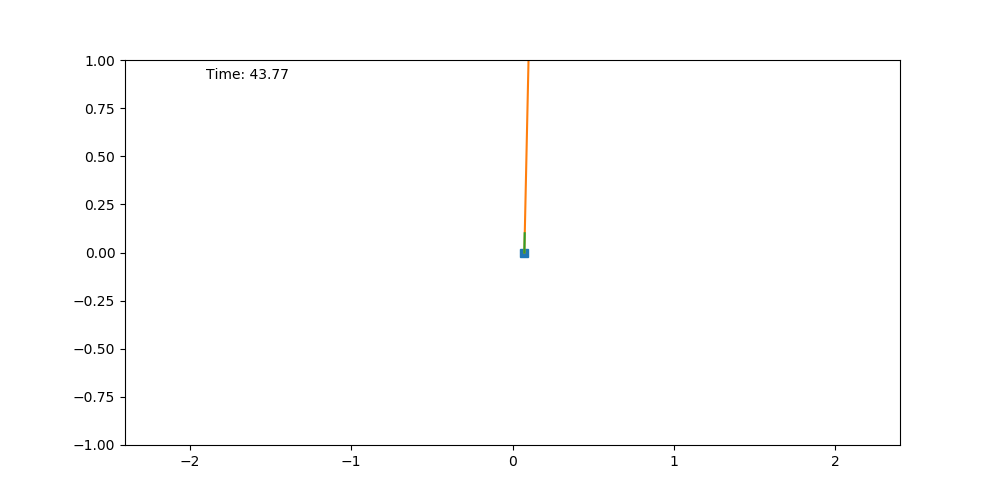

In [9]:
# take an array X and visualize the cart-poles system
visualize = True

if visualize:

    %matplotlib notebook
    import numpy as np
    import pandas as pd
    import seaborn as sns
    import matplotlib
    import matplotlib.pyplot as plt
    import matplotlib.animation as animation
    import time

    l = max(l1,l2)

    Writer = animation.writers['ffmpeg']
    writer = Writer(fps=round(1/h), metadata=dict(artist='Me'), bitrate=1800)

    fig = plt.figure(figsize=(10,5))

    #plt.xlabel('Year',fontsize=12)
    #plt.ylabel('double pole balance',fontsize=12)
    plt.title('Double Pole Balancing',fontsize=12)

    def animate(i):
        plt.cla()
        plt.xlim(-2.4*l, 2.4*l)
        plt.ylim(-l, l)

        data = X_all[i,:] #select data range

        cart_x = data[0]
        cart_y = 0
        pole1_x = l1*math.sin(data[1])
        pole2_x = l2*math.sin(data[2])
        pole1_y = l1*math.cos(data[1])
        pole2_y = l2*math.cos(data[2])

        # draw the 'cart'
        plt.plot(cart_x,0,marker='s')
        # draw the first pole
        plt.plot([cart_x, pole1_x+cart_x], [cart_y, pole1_y+cart_y])
        # draw the second pole
        plt.plot([cart_x, pole2_x+cart_x], [cart_y, pole2_y+cart_y])
        plt.annotate('Time: {:.2f}'.format(i*h), (-2*l*0.95, l*0.9))
        
        

    ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(X_all), repeat=True)

    ani.save('TwoPoleCartMotionRNN.mp4', writer=writer)

